## Модель PyTorch - задача классификации с использованием нейронной сети

Обучение модели на данных, извлекаемых из API /v3/measurings.
Целью обучения является прогнозирование значения surface ['Closed' 'Dry' 'MoreWet' 'Wet' 'WetAndChemicals'] методом классификации.
Результат работы модели - точность классификации на тестовом (проверочном) наборе данных.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.accelerator import current_accelerator
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Подготовка данных для модели

In [3]:
# Прочитаем набор данных и меток из файлов, подготовленных на этапе ELT
dataset = np.loadtxt('dataset.csv', delimiter=',', skiprows=1)
labels = np.loadtxt('labels.csv', delimiter=',', skiprows=1)[:, 0]
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.35, random_state=42)

# Нормализация данных (стандартизация)
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)

dis_dataset_train = TensorDataset(torch.from_numpy(X_train_norm).to(dtype=torch.float32), torch.from_numpy(y_train).to(dtype=torch.long))
dis_dataset_test = TensorDataset(torch.from_numpy(X_test_norm).to(dtype=torch.float32), torch.from_numpy(y_test).to(dtype=torch.long))

batch_size = 6
dis_dataloader_train = DataLoader(dis_dataset_train, batch_size=batch_size, shuffle=True)
dis_dataloader_test = DataLoader(dis_dataset_test, batch_size=len(dis_dataset_test), shuffle=False)

### Создание модели

In [4]:
# Устройство для вычислений
device = current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
# Модель

class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_stack = nn.Sequential(
            nn.Linear(30, 10),
            nn.SELU(),
            nn.Linear(10, 5),
            
        )


    def forward(self, x):
        logits = self.seq_stack(x)
        return logits

model = Dis().to(device)
# print(model)

### Оптимизация параметров модели

In [6]:
# Функция потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss_value, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    accuracy = correct / size
    return loss.item(), accuracy
    

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy = correct / size
    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")
    return loss, accuracy # correct is accuracy

### Обучающий цикл

In [8]:
epochs = 55
train_los = []
train_acc = []
test_los = []
test_acc = []
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(dis_dataloader_train, model, loss_fn, optimizer)
    train_los.append(train_loss)
    train_acc.append(train_accuracy)
    test_loss, test_accuracy = test(dis_dataloader_test, model, loss_fn)
    test_los.append(test_loss)
    test_acc.append(test_accuracy)
    print(f'Epoch {t+1}, Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, Test loss: {test_loss:.4f}, Точность классификации: {test_accuracy:.4f}')
print("Done!")

Epoch 1, Train loss: 1.5371, Train accuracy: 0.0149, Test loss: 1.6844, Точность классификации: 0.0000
Epoch 2, Train loss: 1.4456, Train accuracy: 0.0149, Test loss: 1.6135, Точность классификации: 0.0000
Epoch 3, Train loss: 1.3628, Train accuracy: 0.0149, Test loss: 1.5486, Точность классификации: 0.0000
Epoch 4, Train loss: 1.2837, Train accuracy: 0.0149, Test loss: 1.4892, Точность классификации: 0.6757
Epoch 5, Train loss: 2.2638, Train accuracy: 0.5821, Test loss: 1.4459, Точность классификации: 0.7838
Epoch 6, Train loss: 1.1679, Train accuracy: 0.6269, Test loss: 1.3956, Точность классификации: 0.7838
Epoch 7, Train loss: 1.1076, Train accuracy: 0.6269, Test loss: 1.3501, Точность классификации: 0.7838
Epoch 8, Train loss: 2.2482, Train accuracy: 0.6269, Test loss: 1.3183, Точность классификации: 0.7838
Epoch 9, Train loss: 2.2253, Train accuracy: 0.6269, Test loss: 1.2887, Точность классификации: 0.7838
Epoch 10, Train loss: 0.9917, Train accuracy: 0.6269, Test loss: 1.2514, 

### Кривые обучения

Text(0, 0.5, 'Точность классификации')

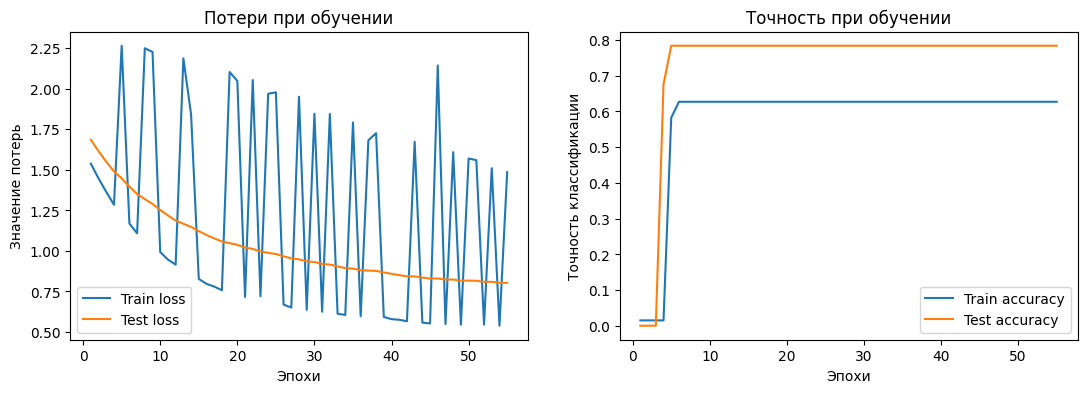

In [9]:
x = range(1, epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(x, train_los, label='Train loss')
ax[0].plot(x, test_los, label='Test loss')
ax[0].legend()
ax[0].set_title("Потери при обучении")
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Значение потерь')

ax[1].plot(x, train_acc, label='Train accuracy')
ax[1].plot(x, test_acc, label='Test accuracy')
ax[1].legend()
ax[1].set_title("Точность при обучении")
ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Точность классификации')